# Tutorial

The `spectral_connectivity` package has two main classes used for computation:
+ `Multitaper`
+ `Connectivity`. 

There is also a function called `multitaper_connectivity` which combines the usage of the two classes and outputs a labeled array, which can be convenient for understanding the output and plotting.

This tutorial will walk you through the usage of each.

## Multitaper

`Multitaper` is used to compute the multitaper Fourier transform of a set of signals. It returns Fourier coefficients that can subsequently be used by the `Connectivity` class to compute frequency-domain metrics on the signals such as power and coherence. 

Let's simulate a set of signals and see how to use the `Multitaper` class. We simulate two signals (`signal`) which oscillate at 200 Hz and are offset in phase by $\frac{\pi}{2}$. We also simulate some white noise to add to the signal (`noise`). We want to compute the multitaper Fourier transform of these two signals.



In [51]:
import numpy as np


frequency_of_interest = 200
sampling_frequency = 1000
time_extent = (0, 60)
n_signals = 2


n_time_samples = ((time_extent[1] - time_extent[0]) * sampling_frequency) + 1

# Signal 1
time = np.linspace(time_extent[0], time_extent[1], num=n_time_samples, endpoint=True)
signal = np.zeros((n_time_samples, n_signals))
signal[:, 0] = np.sin(2 * np.pi * time * frequency_of_interest)

# Signal 2
phase_offset = np.pi / 2
signal[:, 1] = np.sin((2 * np.pi * time * frequency_of_interest) + phase_offset)

noise = np.random.normal(0, 4, signal.shape)


We can plot these two signals with and without the noise added:

(-10.0, 10.0)

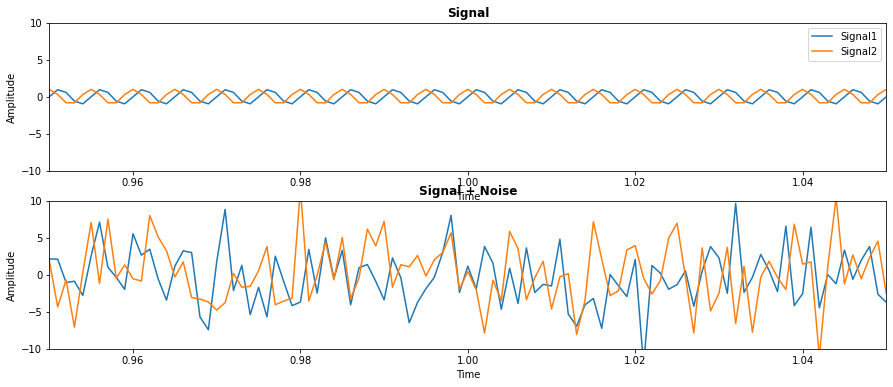

In [52]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 1, figsize=(15, 6))
axes[0].set_title("Signal", fontweight="bold")
axes[0].plot(time, signal[:, 0], label="Signal1")
axes[0].plot(time, signal[:, 1], label="Signal2")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Amplitude")
axes[0].set_xlim((0.95, 1.05))
axes[0].set_ylim((-10, 10))
axes[0].legend()

axes[1].set_title("Signal + Noise", fontweight="bold")
axes[1].plot(time, signal + noise)
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Amplitude")
axes[1].set_xlim((0.95, 1.05))
axes[1].set_ylim((-10, 10))


Now let's import the `Multitaper` class and see how to use it. From the docstring, we can see there are a number of inputs to the class. We will walk through the most important of these inputs.

In [53]:
from spectral_connectivity import Multitaper

Multitaper?

Init signature:
Multitaper(
    time_series,
    sampling_frequency=1000,
    time_halfbandwidth_product=3,
    detrend_type='constant',
    time_window_duration=None,
    time_window_step=None,
    n_tapers=None,
    tapers=None,
    start_time=0,
    n_fft_samples=None,
    n_time_samples_per_window=None,
    n_time_samples_per_step=None,
    is_low_bias=True,
)
Docstring:     
Transform time-domain signal(s) to the frequency domain by using
multiple tapering windows.

Attributes
----------
time_series : array, shape (n_time_samples, n_trials, n_signals) or
                           (n_time_samples, n_signals)
sampling_frequency : float, optional
    Number of samples per time unit the signal(s) are recorded at.
time_halfbandwidth_product : float, optional
    Specifies the time-frequency tradeoff of the tapers and also the number
    of tapers if `n_tapers` is not set.
detrend_type : string or None, optional
    Subtracting a constant or a linear trend from each time window. If Non

### time_series

The most important input is `time_series`. This array is what gets transformed into the frequency domain. The order of dimensions of `time_series` are critical for how the data is processed. The array can either have two or three dimensions.

If the array has two dimensions, then dimension 1 is `time` and dimensions 2 is `signals`. This is how our simulated signal is arranged. We have 50001 samples in the time dimension and 2 signals:

In [54]:
signal.shape


(60001, 2)

If we have three dimensions, dimension 1 is `time`, dimension 2 is `trials`, and dimensions 3 is `signals`. It is important to know note that dimension 2 now has a different meaning in that it represents trials and not signals now. Dimension 3 is now the signals dimension. We will show an example of this later.

### sampling_frequency

The next most important input is the `sampling_frequency`. The `sampling_frequency` is the number of samples per time unit the signal(s) are recorded at. This is set by default to 1000 samples per second. If your signal is sampled at a different rate, this needs to be set. In our simulated signal, we have sampled time at 1000 samples per second:

In [55]:
sampling_frequency


1000

### time_halfbandwidth_product

The `time_halfbandwidth_product` controls the frequency resolution of the Fourier transformed signal. It is equal to the duration of the time window multiplied by the half of the frequency resolution desired (the so-called half bandwidth). Remember that the frequency resolution is the number of consecutive frequencies that can be distinguished. So 2 Hz frequency resolution (which has a 1 Hz half bandwidth) means that we can tell the difference between 9 Hz and 11 Hz, but not 10 Hz.

Setting this parameter will automatically set the number of tapers used in the transform (number of tapers = 2 * `time_halfbandwidth_product` - 1.).

It is outside the scope of this tutorial to fully explain multitaper analysis, but a good introduction can be found in the book: [Case Studies in Neural Data Analysis](https://mark-kramer.github.io/Case-Studies-Python/04.html?highlight=taper#multitaper).

### time_window_duration and time_window_step
The `time_window_duration` controls the duration of the segment of time the transformation is computed on. This is specified in seconds and automatically set to the entire length of the signal(s) if it is not specified. For example, if you want to compute a spectrogram, you need to set the `time_window_duration` to something smaller than the length of the signal(s). Note that setting this will affect the frequency resolution as it is part of the calculation of the `time_halfbandwidth_product` (see above).

The `time_window_step` control how far the time window is slid. By default, the time window is set to slide for the length of the `time_window_duration` so that each time window is independent. Setting the step to smaller than the time window duration will make each time bin dependent.

### Using Multitaper

Now that we know some of the inputs to `Multitaper`, let's see how to use it. We will give the class a noisy signal (`signal + noise`), the sampling frequency (`sampling_frequency`) which we used to simulate the signals and set the `time_halfbandwidth_product` to 5:

In [56]:
multitaper = Multitaper(
    signal + noise, sampling_frequency=sampling_frequency, time_halfbandwidth_product=5
)
multitaper


Multitaper(sampling_frequency=1000, time_halfbandwidth_product=5,
           time_window_duration=60.001, time_window_step=60.001,
           detrend_type='constant', start_time=0, n_tapers=9)

We can see that instantiating the class into the variable (`multitaper`) automatically computed some properties. For example, we can look at `time_window_duration` and `time_window_step`, which both will be the length of the entire signal because we did not specify a shorter duration:

In [57]:
multitaper.time_window_duration


60.001

In [58]:
multitaper.time_window_step


60.001

We can also look at the frequency resolution (which is determined by the `time_halfbandwidth_product` and the `time_window_duration`):

In [59]:
multitaper.frequency_resolution


0.1666638889351844

We can also compute the nyquist frequency, which is the highest resolvable frequency. This is half the sampling frequency.

In [60]:
multitaper.nyquist_frequency


500.0

Note that we haven't run the tranformation yet. To do this we can use the method `fft` to get the Fourier coefficients. 

This will have shape (n_time_windows, n_trials, n_tapers, n_fft_samples, n_signals).

In [61]:
fourier_coefficients = multitaper.fft()
fourier_coefficients.shape


(1, 1, 9, 60750, 2)

We can get the time corresponding to each time window (of length `n_time_windows`) and the frequencies (of length `n_fft_samples`).

In [62]:
multitaper.time


array([0.])

In [63]:
multitaper.frequencies


array([ 0.        ,  0.01646091,  0.03292181, ..., -0.04938272,
       -0.03292181, -0.01646091])

In this case, we have computed the Fourier transform on the entire signal, so we only have a single time corresponding to the beginning of the time window (0.0).

Also note that the frequencies given by the Multitaper class are both positive and negative. This is necessary for certain computations.

Now that we have computed the `fft` we have all the ingredients we need to compute the connectivity measures.

## The Connectivity class

The `Connectivity` class computes the frequency-domain connectivity measures from the Fourier coeffcients. Let's import the class and look at the docstring:

In [64]:
from spectral_connectivity import Connectivity

Connectivity?

Init signature:
Connectivity(
    fourier_coefficients: numpy.ndarray,
    expectation_type: str = 'trials_tapers',
    frequencies: numpy.ndarray = None,
    time: numpy.ndarray = None,
    blocks: int = None,
    dtype: numpy.dtype = <class 'numpy.complex128'>,
)
Docstring:     
Computes brain connectivity measures based on the cross spectral
matrix.

Note that spectral granger methods that require estimation of transfer function
and noise covariance use minimum phase decomposition [1] to decompose
the cross spectral matrix into square roots, which then can be used to
non-parametrically estimate the transfer function and noise covariance.

Attributes
----------
fourier_coefficients : array, shape (n_time_windows, n_trials, n_tapers, n_fft_samples, n_signals)
    The compex-valued coefficients from a fourier transform. Note that
    this is expected to be the two-sided fourier coefficients
    (both the positive and negative lags). This is needed for the
    Granger-based methods to w

From the docstring, we can see that the Connectivity class is initialized with the following parameters:
+ `fourier_coefficients`
+ `expectation_type`
+ `frequencies`,
+ `time`
+ `blocks`
+ `dtype`

Of these, we have already computed the `fourier_coefficients`, `time`, and `frequencies` from the `Multitaper` class (see last section). We will consider the most important remaining parameters in turn:

### expectation_type

The `expectation_type` is perhaps the most important of the parameters to consider. It defines the dimensions of the cross-spectrum that are averaged over. You can average over any combination of:
+ time
+ trials
+ tapers

By default, `Connectivity` averages over trials and tapers (`trials_tapers`), but depending on your usage, you may want to average over the other dimensions. The dimensions you average over is specified by a string with an underscore (`_`)  between the dimensions.

Note that the order of the dimensions must be in the order time, trials, and tapers. So if you wish to average over all three, the correct expectation type is `time_trials_tapers` and not `trials_time_tapers`.

### blocks

The `blocks` parameter can help when the computation of the connectivity measures is taking up a large amount of RAM. The computation of the cross-spectral matrix can be large depending on the number of time samples, frequencies, trials and tapers. Therefore it is sometimes useful to simplify this by breaking this computation up into smaller arrays (`blocks`). The `blocks` parameter controls the number of blocks the matrix is split into. Setting this parameter appropriately is a matter of experimentation, but users should start with the default of 1 and increase it as needed as memory usage becomes a problem.


### Using Connectivity

Okay, now that we understand the parameters, we can now instantiate the class in order to compute the connectivity measures. You can instantiate the class as follows:





In [65]:
connectivity = Connectivity(
    fourier_coefficients=multitaper.fft(),
    expectation_type="trials_tapers",
    frequencies=multitaper.frequencies,
    time=multitaper.time,
    blocks=1,
)


Alternatively, you can also instantiate the class this way, which is a little more convenient code-wise. Note that in this formulation, you do not call the `.fft` method, the class method `from_multitaper` does this for you:

In [66]:
connectivity = Connectivity.from_multitaper(multitaper)


We are now ready to compute the connectivity measures. These all exists as function methods on the class. So for instance, if you want to compute the power of the two signals, we would use the `power` method:

In [67]:
power = connectivity.power()
power.shape


(1, 30375, 2)

Notice here that only the non-negative frequencies are returned (since for real signals, the power spectrum is symmetric). Also since we didn't average over time (the `expectation_type` is "trials_tapers" by default), it is included in the first dimension. We can get the non-negative frequencies using the `frequencies` property. Notice that the shape of the second dimension of power matches:

In [68]:
connectivity.frequencies.shape


(30375,)

We could also average over time here since it is only one dimension. Let's try that here:

In [69]:
connectivity = Connectivity.from_multitaper(
    multitaper, expectation_type="time_trials_tapers", blocks=1
)
connectivity.power().shape


(30375, 2)

Let's plot the power of both signals. Remember that we simulated them both to be 200 Hz oscillations, offset by $\frac{\pi}{2}$ in phase. As expected, the power of both signals is at 200 Hz.

Text(0.5, 0, 'Frequency')

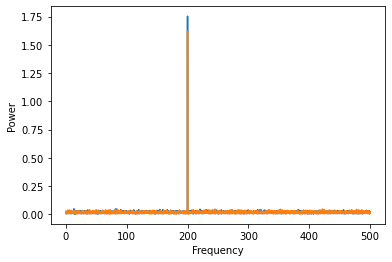

In [70]:
plt.plot(connectivity.frequencies, connectivity.power())
plt.ylabel("Power")
plt.xlabel("Frequency")


Now let's say we want to compute the coherence, a measure of how stable the phase relationships are between the two signals. We use the `coherence_magnitude` method to compute this.

In [71]:
coherence = connectivity.coherence_magnitude()
coherence.shape


(30375, 2, 2)

The coherence comes in shape (n_frequencies, n_signals, n_signals). Because it is symmetric, we only have to plot the relationship from signal1 to signal2. We can see that the signal is more coherent at 200 Hz.

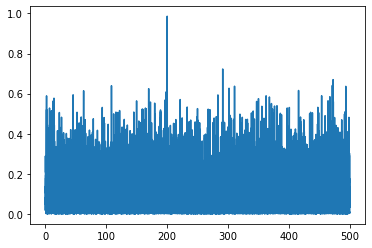

In [72]:
plt.plot(connectivity.frequencies, coherence[:, 0, 1])


### Adding in time

Suppose we want to look at how coherence evolves over time. To do so, we have to go back to the `Multitaper` class and specify the `time_window_duration`.  Here we set it to be 2 seconds. Then we can compute the coherence again from the `Connectivity` class.

In [73]:
multitaper = Multitaper(
    signal + noise,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=5,
    time_window_duration=2.0,
)
connectivity = Connectivity.from_multitaper(
    multitaper, expectation_type="trials_tapers"
)

coherence = connectivity.coherence_magnitude()
coherence.shape


(30, 1000, 2, 2)

 Also note how this changes our frequency resolution.

In [74]:
multitaper.frequency_resolution


5.0

Now we can plot the coherence over time

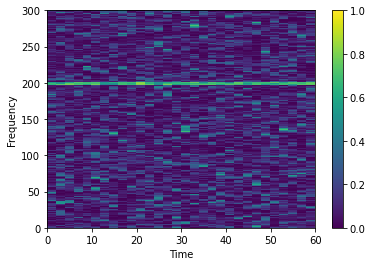

In [75]:
time_grid, freq_grid = np.meshgrid(
    np.append(connectivity.time, time_extent[-1]),
    np.append(connectivity.frequencies, multitaper.nyquist_frequency),
)

mesh = plt.pcolormesh(
    time_grid,
    freq_grid,
    connectivity.coherence_magnitude()[..., 0, 1].squeeze().T,
    vmin=0.0,
    vmax=1.0,
    cmap="viridis",
)
plt.ylim((0, 300))
plt.xlim(time_extent)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()


There are a number of other connectivity measures besides coherence. See the other notebooks for examples on how to use them.

## multitaper_connectivity

There is a third option for how to compute the connectivity measures. The output of this option is a labeled array using the xarray package. This can be convenient because one always knows what the dimensions are. In addition, xarray arrays make plotting easy.

Let's repeat the example above of computing the coherence over time with this interface and see how this makes things easier.

In [76]:
from spectral_connectivity import multitaper_connectivity

coherence = multitaper_connectivity(
    signal + noise,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=5,
    time_window_duration=2.0,
    method="coherence_magnitude",
)

coherence


<xarray.DataArray 'coherence_magnitude' (time: 30, frequency: 1000, source: 2, target: 2)>
array([[[[       nan, 0.15019062],
         [0.15019062,        nan]],

        [[       nan, 0.1590459 ],
         [0.1590459 ,        nan]],

        [[       nan, 0.18504729],
         [0.18504729,        nan]],

        ...,

        [[       nan, 0.13311988],
         [0.13311988,        nan]],

        [[       nan, 0.03534768],
         [0.03534768,        nan]],

        [[       nan, 0.00515984],
         [0.00515984,        nan]]],

...

       [[[       nan, 0.00923646],
         [0.00923646,        nan]],

        [[       nan, 0.0060699 ],
         [0.0060699 ,        nan]],

        [[       nan, 0.09804826],
         [0.09804826,        nan]],

        ...,

        [[       nan, 0.41137038],
         [0.41137038,        nan]],

        [[       nan, 0.27513766],
         [0.27513766,        nan]],

        [[       nan, 0.23863733],
         [0.23863733,        nan]]]])
Coordinates:
  * time       (time) float64 0.0 2.0 4.0 6.0 8.0 ... 50.0 52.0 54.0 56.0 58.0
  * frequency  (frequency) float64 0.0 0.5 1.0 1.5 ... 498.0 498.5 499.0 499.5
  * source     (source) int64 0 1
  * target     (target) int64 0 1
Attributes: (12/15)
    mt_detrend_type:                constant
    mt_frequency_resolution:        5.0
    mt_is_low_bias:                 True
    mt_n_fft_samples:               2000
    mt_n_signals:                   2
    mt_n_tapers:                    9
    ...                             ...
    mt_nyquist_frequency:           500.0
    mt_sampling_frequency:          1000
    mt_start_time:                  0
    mt_time_halfbandwidth_product:  5
    mt_time_window_duration:        2.0
    mt_time_window_step:            2.0

We see that the labeled output conveniently gives us the time and frequencies and signal labels for each dimension. Manipulating xarray by their label name is convenient. Lets' say we only want frequencies between 100 and 300 Hz. We can grab this data in a convenient way:

In [77]:
coherence.sel(frequency=slice(100, 300))


<xarray.DataArray 'coherence_magnitude' (time: 30, frequency: 401, source: 2, target: 2)>
array([[[[       nan, 0.20811035],
         [0.20811035,        nan]],

        [[       nan, 0.23500603],
         [0.23500603,        nan]],

        [[       nan, 0.11101969],
         [0.11101969,        nan]],

        ...,

        [[       nan, 0.13770835],
         [0.13770835,        nan]],

        [[       nan, 0.17166775],
         [0.17166775,        nan]],

        [[       nan, 0.27178454],
         [0.27178454,        nan]]],

...

       [[[       nan, 0.1233722 ],
         [0.1233722 ,        nan]],

        [[       nan, 0.01402156],
         [0.01402156,        nan]],

        [[       nan, 0.01869211],
         [0.01869211,        nan]],

        ...,

        [[       nan, 0.10371416],
         [0.10371416,        nan]],

        [[       nan, 0.13492168],
         [0.13492168,        nan]],

        [[       nan, 0.02686476],
         [0.02686476,        nan]]]])
Coordinates:
  * time       (time) float64 0.0 2.0 4.0 6.0 8.0 ... 50.0 52.0 54.0 56.0 58.0
  * frequency  (frequency) float64 100.0 100.5 101.0 101.5 ... 299.0 299.5 300.0
  * source     (source) int64 0 1
  * target     (target) int64 0 1
Attributes: (12/15)
    mt_detrend_type:                constant
    mt_frequency_resolution:        5.0
    mt_is_low_bias:                 True
    mt_n_fft_samples:               2000
    mt_n_signals:                   2
    mt_n_tapers:                    9
    ...                             ...
    mt_nyquist_frequency:           500.0
    mt_sampling_frequency:          1000
    mt_start_time:                  0
    mt_time_halfbandwidth_product:  5
    mt_time_window_duration:        2.0
    mt_time_window_step:            2.0

We can also plot this in an easy way that puts the labels on the plot:

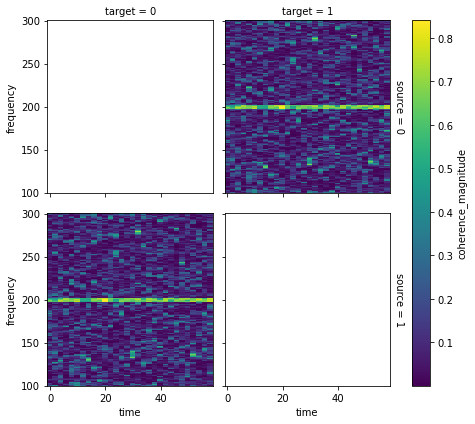

In [78]:
coherence.sel(frequency=slice(100, 300)).plot(
    x="time", y="frequency", row="source", col="target"
)


Fully explaining using xarray arrays is beyond the scope of this tutorial, but see the [xarray documentation](https://docs.xarray.dev/en/stable/) to explore all the possibilities.

## Using GPUs

The `spectral_connectivity` package can do computations on the GPU to speed up the code. To do this, you must have the package `cupy` installed AND have the environmental variable `SPECTRAL_CONNECTIVITY_ENABLE_GPU` set. 

WARNING: the environmental variable must be set before the first import of the `spectral_connectivity` package or the GPU enabled functions will not work.

To check if you are using the GPU on first import, use the logging.basicConfig to get messages that will tell you which version is being used.

It is easiest to use `conda` to install `cupy` because it handles the installation of the correct version of `cudatoolkit`. Note that `cupy` will not work on Macs.

T